# HANDWRITTING RECOGNITION 
CS512 Computer Vision
Authors: 
  - Guillermo Lopez-Areal
  - Victor Bóveda Prado

In [108]:
### USED LIBRARIES
import cv2
import numpy as np
import  tensorflow as tf
from tensorflow  import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.model_selection import train_test_split


In [52]:
#### Globals
sample_file_path = "./samples/test.jpeg" 

#### Image Preprocessing
1. Image enhancement techniques
2. Noise removal
3. Binarization
4. Normalization
5. Skew correction, thinning

In [59]:
def enhance_image(image):
    # Reduce noise using Gaussian blur
    img = cv2.GaussianBlur(image, (5, 5), 0)

    # Increase contrast using histogram equalization
    # img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    # img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    # img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

    # Increase sharpness using unsharp masking
    gaussian_img = cv2.GaussianBlur(img, (9, 9), 10.0)
    img = cv2.addWeighted(img, 1.5, gaussian_img, -0.5, 0)

    # Increase brightness
    img = cv2.convertScaleAbs(img, alpha=1.2, beta=30)

    # Increase saturation using HSV color space
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_hsv[:,:,1] = cv2.add(img_hsv[:,:,1],50)
    img = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)

    
    # Return the enhanced image
    return img

# enhanced_image = enhance_image(sample_file_path)
# cv2.imshow('Enhanced Result', enhanced_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [60]:
def remove_gaussian_noise(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a median filter to the image to remove Gaussian noise
    denoised = cv2.medianBlur(gray, 1)
    
    # Return the denoised image as a NumPy array
    return denoised

In [61]:
def binarize_image(image):    
    # Apply global thresholding to convert the grayscale image to binary
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    
    # Return the binarized image as a NumPy array
    return binary

In [62]:

def normalize_image(image, target_size=(256, 256)):
    # Resize the image to the target size
    resized = cv2.resize(image, target_size)
    
    # Normalize the pixel intensity values to the range [0, 1]
    normalized = resized / 255.0
    
    # Return the normalized image as a NumPy array
    return normalized

In [63]:
def thinning(image, thinning_percent):
    # Make a copy of the input image
    thin = image.copy()

    # Initialize a kernel for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

    # Initialize a variable to keep track of whether any pixels were removed
    has_change = True

    # Compute the maximum number of pixels that can be removed in each iteration
    max_num_change = int(thinning_percent * np.sum(image) / 255)

    # Loop until no pixels can be removed anymore
    while has_change and max_num_change > 0:
        has_change = False

        # Apply morphological erosion to the image using the kernel
        eroded = cv2.erode(thin, kernel)

        # Apply morphological dilation to the eroded image using the kernel
        dilated = cv2.dilate(eroded, kernel)

        # Compute the difference between the eroded and dilated images
        diff = cv2.absdiff(eroded, dilated)

        # Set any pixel in the image that is part of the difference to white
        diff[diff != 0] = 255

        # Count the number of pixels that were set to white
        num_change = np.sum(diff) / 255

        # Set the corresponding pixels in the original image to black
        thin[diff == 255] = 0

        # Check if any pixels were removed in this iteration
        has_change = (num_change > 0)

        # Update the maximum number of pixels that can be removed in each iteration
        max_num_change = int(thinning_percent * np.sum(thin) / 255)

    return thin

In [64]:
enhanced_image = enhance_image(cv2.imread(sample_file_path))
cv2.imshow('Enhanced Result', enhanced_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
remove_gaussian_noise_image = remove_gaussian_noise(enhanced_image)
cv2.imshow('Remove Gaussian Noise Result', remove_gaussian_noise_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
binarized_image = binarize_image(remove_gaussian_noise_image)
cv2.imshow('Binarized Image Result', binarized_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
normalized_image = normalize_image(binarized_image, target_size=(256,256))
cv2.imshow('Normalized Image Result', normalized_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
thinning_image = thinning(normalized_image, 0.05)
cv2.imshow('Skew Correction and Thinning Result', thinning_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

#### Segmentation

In [65]:
def extract_words(binary_image):
    
    binary_8uc1 = cv2.convertScaleAbs(binary_image)

    # Dilate the image to connect nearby text regions
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    dilate = cv2.dilate(binary_8uc1, kernel, iterations=5)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the binary image
    image_copy = binary_image.copy()

    # Iterate through the contours and extract words
    words = []
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        if w > 10 and h > 10 and w/h > 0.5:
            word = image_copy[y:y+h, x:x+w]
            words.append(word)

            # Remove the extracted word from the image copy
            #cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 0, 0), -1)
            # cv2.imshow('Words segmentation:', word)
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()

    return words


words = extract_words(thinning_image)
for word in words:
    cv2.imshow('Words segmentation:', word)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [66]:
p_offset = 0
def extract_letters(word):
    binary_8uc1 = cv2.convertScaleAbs(word)

    # Create an empty list to store the extracted letters
    letters = []
    # Find contours in the word image
    contours, _ = cv2.findContours(binary_8uc1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)

    # Iterate through the contours and extract letters
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        if w > 5 and h > 5:
            letter = word[y-p_offset:y+h+p_offset, x-p_offset:x+w+p_offset]
            letters.append(letter)

    return letters

for word in words:
    letters = extract_letters(word)
    print(len(letters))
    for letter in letters:
        cv2.imshow('Letter segmentation:', letter)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

5
2
7


#### Model: Training and Evaluation


In [72]:
def process_image(image, show= False):
    enhanced_image = enhance_image(image)
    remove_gaussian_noise_image = remove_gaussian_noise(enhanced_image)
    binarized_image = binarize_image(remove_gaussian_noise_image)
    normalized_image = normalize_image(binarized_image, target_size=(28,28))
    thinning_image = thinning(normalized_image, 0.05)
    if(show):
        cv2.imshow('Enhanced Result', enhanced_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        cv2.imshow('Remove Gaussian Noise Result', remove_gaussian_noise_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        cv2.imshow('Binarized Image Result', binarized_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        cv2.imshow('Normalized Image Result', normalized_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        cv2.imshow('Skew Correction and Thinning Result', thinning_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return thinning_image

In [99]:
base_path = "Img/"
train_p = 0.8
val_p   = 0.5
test_p  = 0.05
class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'za', 'zb', 'zc', 'zd', 'ze', 'zf', 'zg', 'zh', 'zi', 'zj', 'zk', 'zl', 'zm', 'zn', 'zo', 'zp', 'zq', 'zr', 'zs', 'zt', 'zu', 'zv', 'zw', 'zx', 'zy', 'zz']
true_labels  = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

print(len(class_labels))

data = []
labels= []
# Loop over each class label and load the corresponding images
for idx, label in enumerate(class_labels):
    # Define the path to the directory containing the images for this class
    class_path = os.path.join(base_path, label)
    
    # Loop over each image in the class directory and load it
    for filename in os.listdir(class_path):
        # Load the image and add it to the data list
        image = cv2.imread(os.path.join(class_path, filename))
        data.append(process_image(image))
        
        # Add the corresponding label to the labels list
        labels.append(idx)
        
    
# Convert the data and labels lists to NumPy arrays
data = np.array(data)
labels = np.array(labels)
# Split the dataset into training, testing, and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)
X_train, X_val,  Y_train, Y_val  = train_test_split(X_train, Y_train, test_size=0.1, stratify=Y_train)

# Add channel dimension to the input data
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

# Convert the labels to one-hot encoding
Y_train_c = keras.utils.to_categorical(Y_train, num_classes=62)
Y_test_c  = keras.utils.to_categorical(Y_test, num_classes=62)
Y_val_c   = keras.utils.to_categorical(Y_val, num_classes=62)

# Print the shapes of the training, testing, and validation sets
print('Training set:',  X_train.shape, Y_train.shape)
train_dataset = (X_train, Y_train)
print('Testing set:',   X_test.shape,  Y_test.shape)
test_dataset = (X_test, Y_test)
print('Validation set:', X_val.shape,  Y_val.shape)
val_dataset = (X_val, Y_val)



62
Training set: (2455, 28, 28, 1) (2455,)
Testing set: (682, 28, 28, 1) (682,)
Validation set: (273, 28, 28, 1) (273,)


In [106]:
# Define the model
class HandwritingModel(keras.Model) :
    def __init__(self):
        super(HandwritingModel,self).__init__()
        self.conv1 = keras.layers.Conv2D(32,3,activation='relu', input_shape=(28,28,1))
        self.batch_norm1 = keras.layers.BatchNormalization()
        self.pool1 = keras.layers.MaxPooling2D(2)
        
        self.conv2 = keras.layers.Conv2D(128,3,activation='relu')
        self.batch_norm2 = keras.layers.BatchNormalization()
        self.pool2 = keras.layers.MaxPooling2D(2)
        
        self.flatten = keras.layers.Flatten()
        
        self.Dense1 = keras.layers.Dense(128,activation='relu')
        self.dropout = keras.layers.Dropout(0.1)
        self.Dense2 = keras.layers.Dense(62,activation='softmax')
    
    def call(self, inputs) :
        x = self.conv1(inputs)
        x = self.batch_norm1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)
        
        x = self.flatten(x)
        x = self.Dense1(x)
        x = self.dropout(x)
        
        return self.Dense2(x)

# Create an instance of the model and compile it
model = HandwritingModel()
model.compile(optimizer=keras.optimizers.Adam(0.001),
             loss=keras.losses.CategoricalCrossentropy(),
             metrics=['acc'])

# Let's train our model
batch_size = 48

# Used to merge both tensors into one 
img_datagen = ImageDataGenerator()
train_augmented_data = img_datagen.flow(X_train, Y_train_c, batch_size=batch_size)
validation_augmented_data = img_datagen.flow(X_val, Y_val_c, batch_size=batch_size)


steps_per_epoch  = np.ceil(len(X_train)/batch_size)
validation_steps = np.ceil(len(X_val)/batch_size)

history = model.fit(train_augmented_data, steps_per_epoch=steps_per_epoch, epochs=30, validation_data=validation_augmented_data, validation_steps=validation_steps)
model.summary()

model.save_weights('handwriting_model.h5')   

Epoch 1/30
52/52 [==============================] - 5s 87ms/step - loss: 4.0378 - acc: 0.0619 - val_loss: 4.1329 - val_acc: 0.0256
Epoch 2/30
52/52 [==============================] - 4s 75ms/step - loss: 3.3342 - acc: 0.1662 - val_loss: 4.8576 - val_acc: 0.0147
Epoch 3/30
52/52 [==============================] - 4s 74ms/step - loss: 2.4817 - acc: 0.3397 - val_loss: 6.5305 - val_acc: 0.0147
Epoch 4/30
52/52 [==============================] - 3s 62ms/step - loss: 1.7411 - acc: 0.5145 - val_loss: 7.8655 - val_acc: 0.0147
Epoch 5/30
52/52 [==============================] - 3s 62ms/step - loss: 1.2253 - acc: 0.6428 - val_loss: 7.7989 - val_acc: 0.0147
Epoch 6/30
52/52 [==============================] - 3s 62ms/step - loss: 0.8534 - acc: 0.7540 - val_loss: 7.2207 - val_acc: 0.0256
Epoch 7/30
52/52 [==============================] - 4s 71ms/step - loss: 0.6137 - acc: 0.8037 - val_loss: 7.4061 - val_acc: 0.0147
Epoch 8/30
52/52 [==============================] - 4s 73ms/step - loss: 0.4575 - a

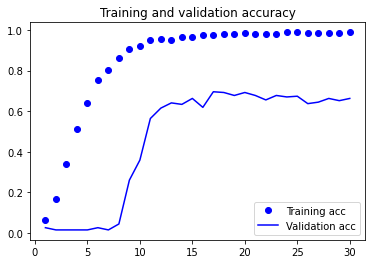

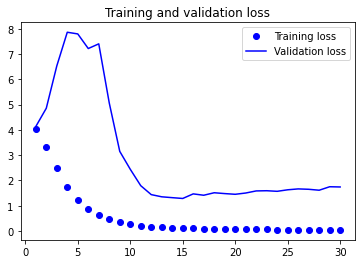

In [109]:
acc = history.history['acc']
val_acc =  history.history['val_acc']
loss =  history.history['loss']
val_loss =  history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# Plot loss
plt.figure()
plt.plot(epochs, loss, 'bo', label =  'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

22/22 [==============================] - 0s 8ms/step - loss: 1.8104 - acc: 0.6540
Test accuracy: 0.6539589166641235
Test loss: 1.810415267944336
The result is N its label is q


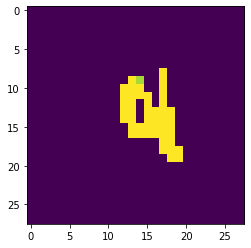

In [124]:
# Evaluate the model on the test set
element = 0
test_loss, test_acc = model.evaluate(X_test, Y_test_c)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)
plt.imshow(X_test[element])
result = model.predict(X_test[element:element+1])
print(f'The result is {true_labels[np.argmax(result)]} its label is {true_labels[np.argmax(Y_test_c[element:element+1])]}')

#### 4.Test with handwriten image

The OCR has interpreted: GdJPmWW zB mTTYp 


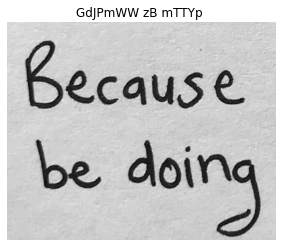

In [134]:
output = ""
for word in reversed(words):
    letters = extract_letters(word)
    for letter in reversed(letters):
        # cv2.imshow('Letter segmentation:', letter)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        letter = cv2.resize(letter, (28,28))
        letter = np.expand_dims(letter, axis=-1)
        letter = np.expand_dims(letter, axis=0)
        o = model.predict(letter)
        output += true_labels[np.argmax(o)]
    output += " " #Add blanck to split words

print(f"The OCR has interpreted: {output}")
# Leer la imagen con Matplotlib
imagen = cv2.imread(sample_file_path, cv2.IMREAD_GRAYSCALE)

# Mostrar la imagen con Matplotlib
plt.imshow(imagen, cmap="gray")
plt.title(f"{output}")
plt.axis('off')
plt.show()